In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from plotly.colors import DEFAULT_PLOTLY_COLORS as default_colors
from plotly.subplots import make_subplots

from QSSBuilder import QSSBuilder

# Calculating many steady-states.
Here we loop through a whole bunch of states and calculate the output power, reeling factor, and other outputs for it. This is then saved as a csv file in the results folder.

In [2]:
# qss = QSSBuilder("MegAWES")  # When you want to start fresh - name of one of the configurations in "parameters".
qss = QSSBuilder.from_csv("MegAWES")  # When you want to continue from an existing csv.

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


c:\Users\jesse\Documents\TU\MSc\Thesis\Code\AWE_winch_control_heavy_kites\src\QSSBuilder.py:221: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"../results/{param_name}.csv", index_col=0)


Done loading MegAWES.csv


In [ ]:
# Combine all possible combinations of states, and calculate the output if it didn't
# exist in the DataFrame already. This might even take a while when there re no new
# combinations as it takes a while to check that.
qss.add_steady_states(
    {
        "vw_mps": np.unique(np.linspace(0, 30, 13)),
        "Lt_m": np.unique(np.linspace(500, 1500, 3, dtype=int)),
        "phi_deg": [0.0, 17.5, 35],
        "beta_deg": [0.0, 30],
        "chi_deg": np.unique(np.linspace(0, 180, 5, dtype=int)),
        # TODO: Smarter way to find different Ftk_N that work than looping over all values.
        # Use dtype int for the merge into an existing DataFrame to be less error-prone.
        # Otherwise it sometimes couldn't match two floats with each other. Integer
        # precision is also more than enough here.
        # "Ftk_N": np.unique(np.logspace(1, 7, 103, dtype=int)),
        "Ftk_N": np.unique(np.arange(10, 1e7, 2500, dtype=int)),
    }
)
qss.save_df()

In [3]:
qss_massless = QSSBuilder.from_csv("MegAWES_massless")

Done loading MegAWES_massless.csv


In [ ]:
qss_massless.add_steady_states(
    {
        "vw_mps": np.unique(np.linspace(0, 30, 13)),
        "Lt_m": np.unique(np.linspace(500, 1500, 3, dtype=int)),
        "phi_deg": [0.0, 17.5, 35],
        "beta_deg": [0.0, 30],
        "chi_deg": np.unique(np.linspace(0, 180, 5, dtype=int)),
        "Ftk_N": np.unique(np.arange(10, 1e7, 2500, dtype=int)),
    }
)
qss_massless.save_df()

# Cleaning the data

In [4]:
from helper.plotting_settings import set_labels, FULLSIZE, PARTSIZE

# Interactive plots when using vscode
%matplotlib widget

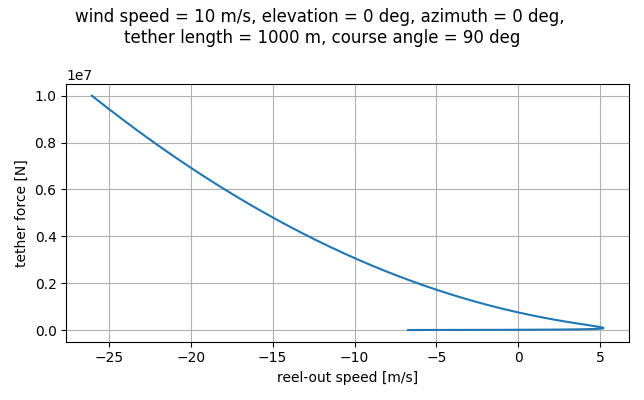

In [5]:
# Show what the problem is
beta_deg_bar = 0
phi_deg_bar = 0
chi_deg_bar = 90
Lt_m_bar = 1000
vw_mps_bar = 10
temp = qss.df[
    (qss.df["beta_deg"] == beta_deg_bar)
    & (qss.df["phi_deg"] == phi_deg_bar)
    & (qss.df["chi_deg"] == chi_deg_bar)
    & (qss.df["Lt_m"] == Lt_m_bar)
    & (qss.df['vw_mps'] == vw_mps_bar)
].sort_values('Ftg_N', ascending=False)

fig, ax = plt.subplots(1, 1, figsize=PARTSIZE)
fig.suptitle(f"wind speed = {vw_mps_bar} m/s, elevation = {beta_deg_bar} deg, azimuth = {phi_deg_bar} deg, \ntether length = {Lt_m_bar} m, course angle = {chi_deg_bar} deg")


sns.lineplot(temp, x="vr_mps", y='Ftg_N', ax=ax, sort=False)
ax.grid()
set_labels(ax)
plt.tight_layout()

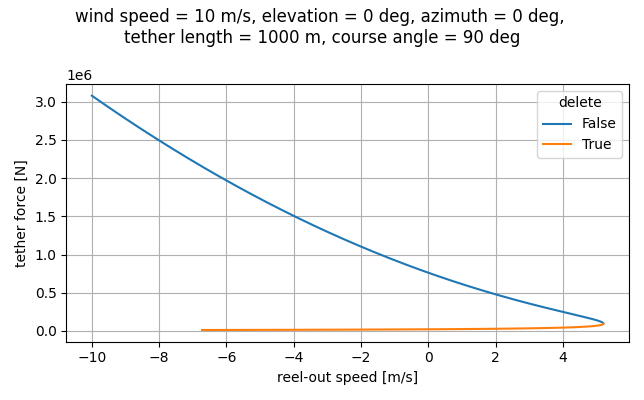

In [8]:
# Tether force is sorted from high to low, so as soon as the change in reeling speed is
# negative we delete those values.
temp['delete'] = temp['vr_mps'].diff() < 0
temp = temp[temp['vr_mps']>-10]
fig, ax = plt.subplots(1, 1, figsize=PARTSIZE)
fig.suptitle(f"wind speed = {vw_mps_bar} m/s, elevation = {beta_deg_bar} deg, azimuth = {phi_deg_bar} deg, \ntether length = {Lt_m_bar} m, course angle = {chi_deg_bar} deg")


sns.lineplot(temp, x="vr_mps", y='Ftg_N', hue='delete', ax=ax, sort=False)
ax.grid()
set_labels(ax)
plt.tight_layout()
plt.savefig('..\\results\\before_cleaning.png')

In [7]:
# Mark what we want to delete.
qss.df["to_delete"] = False
for beta_deg in qss.df["beta_deg"].unique():
    for phi_deg in qss.df["phi_deg"].unique():
        for chi_deg in qss.df["chi_deg"].unique():
            for Lt_m in qss.df["Lt_m"].unique():
                for vw_mps in qss.df["vw_mps"].unique():
                    temp = qss.df[
                        (qss.df["beta_deg"] == beta_deg)
                        & (qss.df["phi_deg"] == phi_deg)
                        & (qss.df["chi_deg"] == chi_deg)
                        & (qss.df["Lt_m"] == Lt_m)
                        & (qss.df["vw_mps"] == vw_mps)
                    ].sort_values("Ftg_N", ascending=False)
                    qss.df.loc[temp.index, 'to_delete'] = temp['vr_mps'].diff() < 0

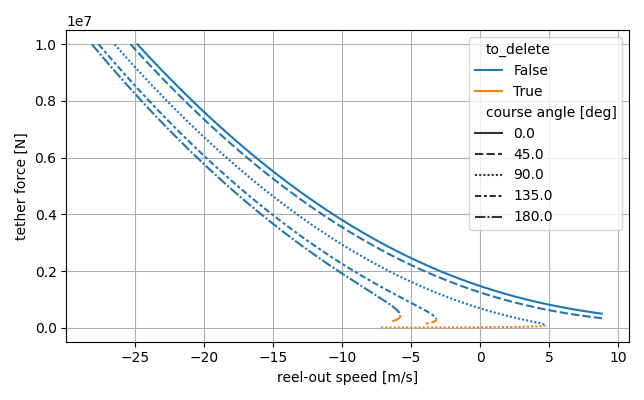

In [8]:
temp = qss.df[
    (qss.df["beta_deg"] == 0)
    & (qss.df["phi_deg"] == 17.5)
    # & (qss.df["chi_deg"] == 90)
    & (qss.df["Lt_m"] == 1000)
    & (qss.df['vw_mps'] == 10)
].sort_values('Ftg_N', ascending=False)

fig, ax = plt.subplots(1, 1, figsize=PARTSIZE)

sns.lineplot(temp, x="vr_mps", y='Ftg_N', style='chi_deg', hue='to_delete', ax=ax, sort=False)
ax.grid()
set_labels(ax)
plt.tight_layout()

In [9]:
qss.df = qss.df[qss.df['to_delete'] == False]

In [10]:
qss.df.to_csv("..\\results\\MegAWES_cleaned.csv")

# Processing
We want to find the optimal state to operate in. So by sorting the values by generated power, we can find the combination of beta, phi, chi, Lt, and vw that yields the highest power. The optimal tether force (at the kite and ground), reeling factor, reeling speed, and power will be saved as `_star` variables in the DataFrame.
- [ ] Make sure to already have run the `quasi_steady_state_massless_analysis.ipynb` to compare these results to.

In [11]:
temp = qss.df.sort_values("P_W", ascending=False)
qss_star = temp.drop_duplicates(
    ["beta_deg", "phi_deg", "chi_deg", "Lt_m", "vw_mps"],
    keep="first",
    ignore_index=True,
).copy()
star_dict = {
    "Ftk_N": "Ftk_N_star",
    "f": "f_star",
    "Ftg_N": "Ftg_N_star",
    "P_W": "P_W_star",
    "vr_mps": "vr_mps_star",
}
qss_star = qss_star.rename(columns=star_dict)

temp = qss_massless.df.sort_values("P_W", ascending=False)
qss_massless_star = temp.drop_duplicates(
    ["beta_deg", "phi_deg", "chi_deg", "Lt_m", "vw_mps"],
    keep="first",
    ignore_index=True,
).copy()
qss_massless_star = qss_massless_star.rename(columns=star_dict)

qss_massless_analytical = pd.read_csv("../results/MegAWES_massless_analytical.csv")
qss_massless_analytical_star = pd.read_csv(
    "../results/MegAWES_massless_analytical_star.csv"
)

In [12]:
qss_star["param_name"] = "MegAWES"
qss_massless_star["param_name"] = "MegAWES_massless"
qss_massless_analytical_star["param_name"] = "MegAWES_massless_analytical"
df_massless = pd.concat(
    [qss_massless_star, qss_massless_analytical_star], ignore_index=True
)
df = pd.concat(
    [qss_star, qss_massless_star, qss_massless_analytical_star], ignore_index=True
)

In [13]:
qss_star.to_csv("..\\results\\MegAWES_star.csv")

# Compare analytical and qsm massless

In [14]:
import helper.my_plotly_themes

On this screen 15.75 cm is 675 pixels wide.


In [15]:
fig = px.line(
    df_massless,
    x="vw_mps",
    y="P_W_star",
    color="param_name",
    symbol="Lt_m",
    facet_col="beta_deg",
    facet_row="phi_deg",
)
fig.write_image("../results/qsm_massless_vs_analytical.png")
fig.show()

# Plotting

### Loyd

In [ ]:
# fFP (reeling factor, tether force, power) graph for massless system for beta and phi
# equal to zero and a certain tether length.
temp = qss_massless_analytical_star[
    (qss_massless_analytical_star["beta_deg"] == 0)
    & (qss_massless_analytical_star["phi_deg"] == 0)
    & (qss_massless_analytical_star["Lt_m"] == 1000)
]

fig, axs = plt.subplots(1, 3, figsize=FULLSIZE)

for i, y in enumerate(["f_star", "Ftg_N_star", "P_W_star"]):
    sns.lineplot(temp, x="vw_mps", y=y, ax=axs[i])
    axs[i].grid()

set_labels(axs)
plt.tight_layout()
plt.savefig("../results/fFP_Loyd.png")


In [ ]:
# vr-Ft Loyd
fig, ax = plt.subplots(1, 1, figsize=PARTSIZE)
sns.lineplot(temp, x="vr_mps_star", y="Ftg_N_star", ax=ax)
ax.grid()
set_labels(ax)
plt.tight_layout()
plt.savefig("../results/vrFt_Loyd.png")


### Beta and phi

In [ ]:
# fFP graph.
temp = qss_massless_analytical_star[(qss_massless_analytical_star["Lt_m"] == 1000)]

fig, axs = plt.subplots(1, 3, figsize=FULLSIZE)

for i, y in enumerate(["f_star", "Ftg_N_star", "P_W_star"]):
    sns.lineplot(temp, x="vw_mps", y=y, hue="beta_deg", style="phi_deg", ax=axs[i])
    axs[i].grid()
    if i != 2:
        axs[i].get_legend().set_visible(False)

set_labels(axs)
plt.tight_layout()
plt.savefig("../results/fFP_betaphi.png")

In [ ]:
# vr-Ft
# This is a very interesting figure. It plots the ideal vr-Ft graph. If the winch
# ensures that the kite stays on this optimal vr-Ft line, it will operate at optimal
# (instantaneous) power output. As you can see, the lines for different elevation and
# azimuth are on top of each other. So one strategy can be used (when ignoring the
# effect of tether length and mass).
fig, ax = plt.subplots(1, 1, figsize=PARTSIZE)
sns.lineplot(
    temp, x="vr_mps_star", y="Ftg_N_star", hue="beta_deg", style="phi_deg", ax=ax
)
ax.grid()
set_labels(ax)
plt.tight_layout()
plt.savefig("../results/vrFt_betaphi.png")

## Tether length

In [ ]:
# fFP graph
beta_deg_bar = 0
phi_deg_bar = 0
temp = qss_massless_analytical_star[
    (qss_massless_analytical_star["beta_deg"] == beta_deg_bar)
    & (qss_massless_analytical_star["phi_deg"] == phi_deg_bar)
]

fig, axs = plt.subplots(1, 3, figsize=FULLSIZE)
fig.suptitle(f"elevation = {beta_deg_bar} deg, azimuth = {phi_deg_bar} deg")

for i, y in enumerate(["f_star", "Ftg_N_star", "P_W_star"]):
    sns.lineplot(temp, x="vw_mps", y=y, hue="Lt_m", ax=axs[i])
    axs[i].grid()
    if i != 2:
        axs[i].get_legend().set_visible(False)

set_labels(axs)
plt.tight_layout()
plt.savefig("../results/fFP_Lt.png")


In [ ]:
# vr-Ft
fig, ax = plt.subplots(1, 1, figsize=PARTSIZE)
fig.suptitle(f"elevation = {beta_deg_bar} deg, azimuth = {phi_deg_bar} deg")

sns.lineplot(temp, x="vr_mps_star", y="Ftg_N_star", hue="Lt_m", ax=ax)

ax.grid()
set_labels(ax)
plt.tight_layout()
plt.savefig("../results/vrFt_Lt.png")

### Add mass, variable chi.

C:\Users\jesse\AppData\Local\Temp\ipykernel_15604\1233302249.py:18: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



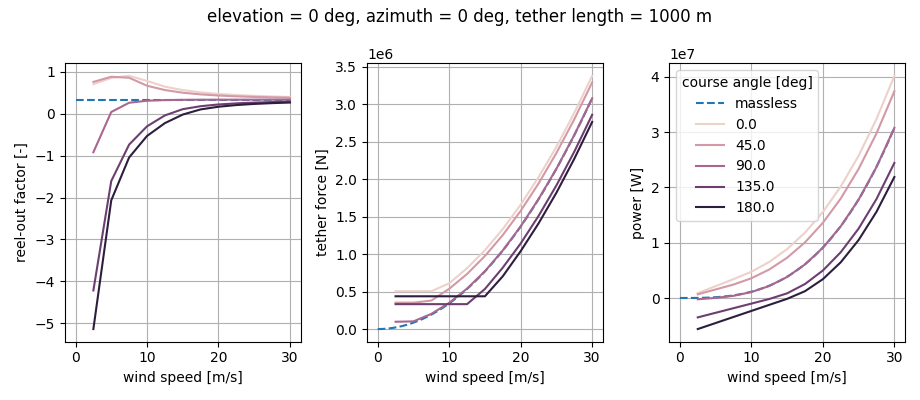

In [33]:
# fFP graph
beta_deg_bar = 0
phi_deg_bar = 0
# chi_deg_bar = 90
Lt_m_bar = 1000
temp = qss_star[
    (qss_star["Lt_m"] == Lt_m_bar)
    & (qss_star["beta_deg"] == beta_deg_bar)
    & (qss_star["phi_deg"] == phi_deg_bar)
    # & (qss_star['chi_deg'] == chi_deg_bar)
]
temp2 = qss_massless_analytical_star[
    (qss_massless_analytical_star["Lt_m"] == Lt_m_bar)
    & (qss_massless_analytical_star["beta_deg"] == beta_deg_bar)
    & (qss_massless_analytical_star["phi_deg"] == phi_deg_bar)
]

fig, axs = plt.subplots(1, 3, figsize=FULLSIZE)
fig.suptitle(f"elevation = {beta_deg_bar} deg, azimuth = {phi_deg_bar} deg, tether length = {Lt_m_bar} m")

for i, y in enumerate(["f_star", "Ftg_N_star", "P_W_star"]):
    sns.lineplot(temp2, x="vw_mps", y=y, ax=axs[i], label="massless")
    axs[i].lines[0].set_linestyle("--")
    sns.lineplot(temp, x="vw_mps", y=y, hue="chi_deg", ax=axs[i])
    axs[i].grid()
    if i != 2:
        axs[i].get_legend().set_visible(False)

set_labels(axs)
plt.tight_layout()
plt.savefig("../results/fFP_mass.png")


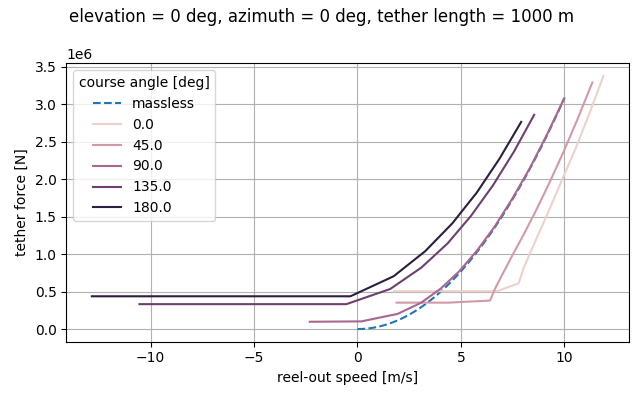

In [34]:
# vr-Ft
fig, ax = plt.subplots(1, 1, figsize=PARTSIZE)
fig.suptitle(f"elevation = {beta_deg_bar} deg, azimuth = {phi_deg_bar} deg, tether length = {Lt_m_bar} m")

sns.lineplot(temp2, x="vr_mps_star", y="Ftg_N_star", ax=ax, label="massless")
ax.lines[0].set_linestyle("--")
sns.lineplot(temp, x="vr_mps_star", y="Ftg_N_star", hue="chi_deg", ax=ax)

ax.grid()
set_labels(ax)
plt.tight_layout()
plt.savefig("../results/vrFt_mass.png")


### With mass, chi=90 but variable beta and phi again.
Massless underestimates the effect of beta and phi (right?)

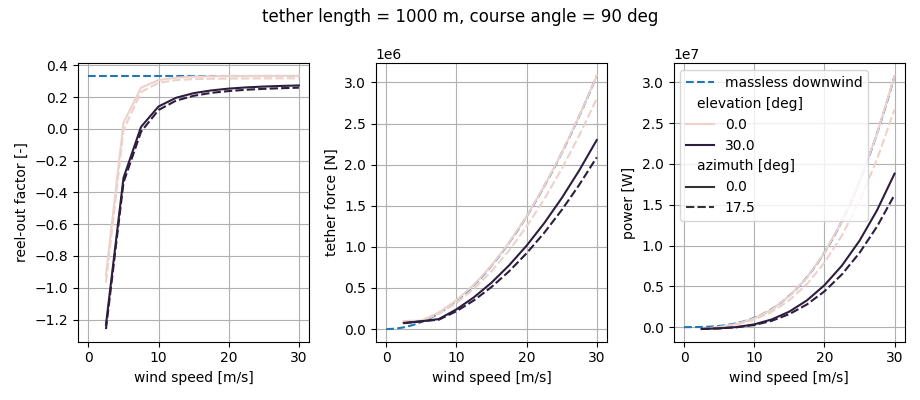

In [16]:
# fFP graph
beta_deg_bar = 0
phi_deg_bar = 0
phi_deg_max = 18
chi_deg_bar = 90
Lt_m_bar = 1000
temp = qss_star[
    (qss_star["Lt_m"] == Lt_m_bar)
    # & (qss_star["beta_deg"] == beta_deg_bar)
    & (qss_star["phi_deg"] < phi_deg_max)
    & (qss_star["chi_deg"] == chi_deg_bar)
]
temp2 = qss_massless_analytical_star[
    (qss_massless_analytical_star["Lt_m"] == Lt_m_bar)
    & (qss_massless_analytical_star["beta_deg"] == beta_deg_bar)
    & (qss_massless_analytical_star["phi_deg"] == phi_deg_bar)
]

fig, axs = plt.subplots(1, 3, figsize=FULLSIZE)
fig.suptitle(f"tether length = {Lt_m_bar} m, course angle = {chi_deg_bar} deg")

for i, y in enumerate(["f_star", "Ftg_N_star", "P_W_star"]):
    sns.lineplot(temp2, x="vw_mps", y=y, ax=axs[i], label="massless downwind")
    axs[i].lines[0].set_linestyle("--")
    sns.lineplot(temp, x="vw_mps", y=y, ax=axs[i], hue='beta_deg', style='phi_deg')
    axs[i].grid()
    if i != 2:
        axs[i].get_legend().set_visible(False)

set_labels(axs)
plt.tight_layout()
plt.savefig("../results/fFP_mass_betaphi.png")


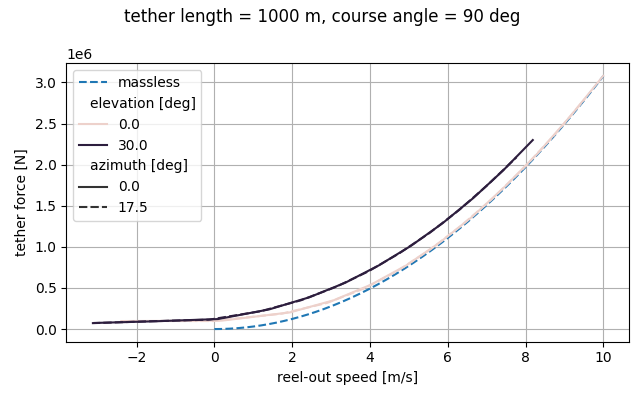

In [17]:
# vr-Ft
fig, ax = plt.subplots(1, 1, figsize=PARTSIZE)
fig.suptitle(
    f"tether length = {Lt_m_bar} m, course angle = {chi_deg_bar} deg"
)

sns.lineplot(temp2, x="vr_mps_star", y="Ftg_N_star", ax=ax, label="massless")
ax.lines[0].set_linestyle("--")
sns.lineplot(
    temp,
    x="vr_mps_star",
    y="Ftg_N_star",
    ax=ax,
    hue="beta_deg",
    style="phi_deg",
)

ax.grid()
set_labels(ax)
plt.tight_layout()
plt.savefig("../results/vrFt_mass_betaphi.png")

### Also for changing chi

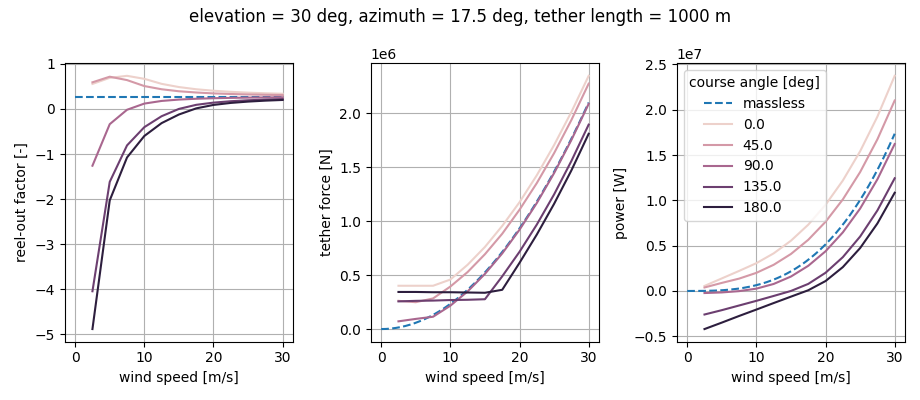

In [16]:
# fFP graph
beta_deg_bar = 30
phi_deg_bar = 17.5
# chi_deg_bar = 90
Lt_m_bar = 1000
temp = qss_star[
    (qss_star["Lt_m"] == Lt_m_bar)
    & (qss_star["beta_deg"] == beta_deg_bar)
    & (qss_star["phi_deg"] == phi_deg_bar)
    # & (qss_star['chi_deg'] == chi_deg_bar)
]
temp2 = qss_massless_analytical_star[
    (qss_massless_analytical_star["Lt_m"] == Lt_m_bar)
    & (qss_massless_analytical_star["beta_deg"] == beta_deg_bar)
    & (qss_massless_analytical_star["phi_deg"] == phi_deg_bar)
]

fig, axs = plt.subplots(1, 3, figsize=FULLSIZE)
fig.suptitle(f"elevation = {beta_deg_bar} deg, azimuth = {phi_deg_bar} deg, tether length = {Lt_m_bar} m")

for i, y in enumerate(["f_star", "Ftg_N_star", "P_W_star"]):
    sns.lineplot(temp2, x="vw_mps", y=y, ax=axs[i], label="massless")
    axs[i].lines[0].set_linestyle("--")
    sns.lineplot(temp, x="vw_mps", y=y, hue="chi_deg", ax=axs[i])
    axs[i].grid()
    if i != 2:
        axs[i].get_legend().set_visible(False)

set_labels(axs)
plt.tight_layout()
plt.savefig("../results/fFP_mass_chi.png")


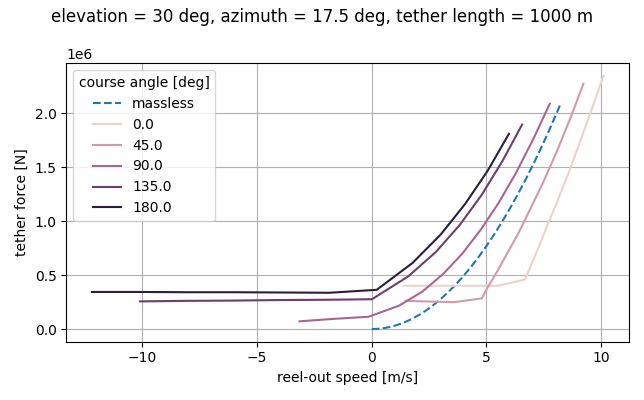

In [17]:
# vr-Ft
fig, ax = plt.subplots(1, 1, figsize=PARTSIZE)
fig.suptitle(f"elevation = {beta_deg_bar} deg, azimuth = {phi_deg_bar} deg, tether length = {Lt_m_bar} m")

sns.lineplot(temp2, x="vr_mps_star", y="Ftg_N_star", ax=ax, label="massless")
ax.lines[0].set_linestyle("--")
sns.lineplot(temp, x="vr_mps_star", y="Ftg_N_star", hue="chi_deg", ax=ax)

ax.grid()
set_labels(ax)
plt.tight_layout()
plt.savefig("../results/vrFt_mass_chi.png")

## Alternative view: also have a category for wind speed.

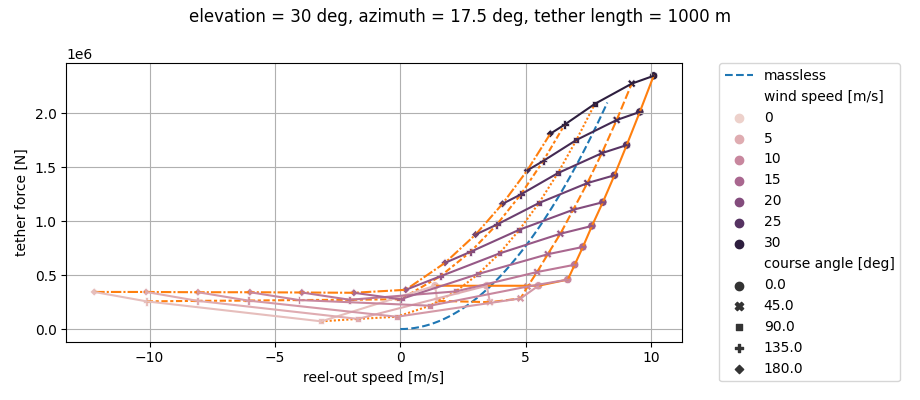

In [32]:
# vr-Ft
fig, ax = plt.subplots(1, 1, figsize=FULLSIZE)
fig.suptitle(
    f"elevation = {beta_deg_bar} deg, azimuth = {phi_deg_bar} deg, tether length = {Lt_m_bar} m"
)

sns.lineplot(temp2, x="vr_mps_star", y="Ftg_N_star", ax=ax, label="massless")
ax.lines[0].set_linestyle("--")
sns.lineplot(temp, x="vr_mps_star", y="Ftg_N_star", style="chi_deg", ax=ax, legend=False)
sns.lineplot(temp, x="vr_mps_star", y="Ftg_N_star", hue="vw_mps", ax=ax, legend=False)
sns.scatterplot(temp, x="vr_mps_star", y="Ftg_N_star", style='chi_deg', hue="vw_mps", ax=ax)

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.025))
ax.grid()
set_labels(ax)
plt.tight_layout()
plt.savefig("../results/vrFt_mass_chi_vw.png")

### Making the average operating condition
See my MSc report

In [35]:
def least_squares(X, y):
    return np.dot(np.dot(np.linalg.inv(np.dot(X.transpose(), X)), X.transpose()), y)

In [36]:
# Fitting to the curve between 0.5e6 and 1e6.
beta_deg_bar = 30
phi_deg_bar = 17.5
chi_deg_bar = 90
Lt_m_bar = 1000
temp = qss_star[
    (qss_star["Lt_m"] == Lt_m_bar)
    & (qss_star["beta_deg"] == beta_deg_bar)
    & (qss_star["phi_deg"] == phi_deg_bar)
    & (qss_star['chi_deg'] == chi_deg_bar)
]

Fmin = 0.5e6
Fmax = 1.0e6
fit_index = temp["Ftg_N_star"][
    (temp["Ftg_N_star"] > Fmin)
    & (temp["Ftg_N_star"] < Fmax)
    & (~temp["Ftg_N_star"].isna())
].index

vr = temp.loc[fit_index, "vr_mps_star"].values
vr2 = vr**2
ones = np.ones_like(vr)
X = np.asarray([ones, vr, vr2]).transpose()

y = temp.loc[fit_index, "Ftg_N_star"].values
theta_hat = least_squares(X, y)
theta_hat


array([187486.75991941,   7784.00032003,  30865.20268423])

In [37]:
def abc(a, b, c):
    return (-b + np.sqrt(b**2 - 4 * a * c)) / (2 * a)


In [38]:
# Need to find the vr for which we reach Flim.
vr_power_lim = abc(theta_hat[2], theta_hat[1], theta_hat[0] - Fmax)
print(vr_power_lim, Fmax, vr_power_lim * Fmax / 1e6)


5.006200257395739 1000000.0 5.006200257395739


In [39]:
def my_winch_strategy(vr):
    F_star = theta_hat[0] + theta_hat[1] * vr + theta_hat[2] * vr**2

    F_star[vr < 0] = Fmin
    F_star = np.maximum(F_star, Fmin)
    # F_star = np.clip(F_star, Fmin, Fmax)
    return F_star


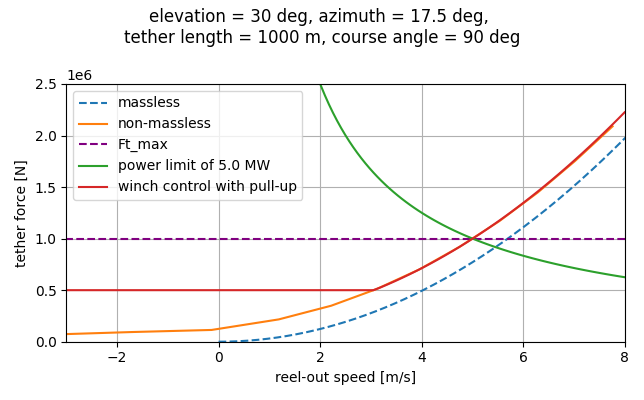

In [49]:
# vr-Ft
beta_deg_bar = 30
phi_deg_bar = 17.5
chi_deg_bar = 90
Lt_m_bar = 1000
temp = qss_star[
    (qss_star["Lt_m"] == Lt_m_bar)
    & (qss_star["beta_deg"] == beta_deg_bar)
    & (qss_star["phi_deg"] == phi_deg_bar)
    & (qss_star["chi_deg"] == chi_deg_bar)
]
temp2 = qss_massless_analytical_star[
    (qss_massless_analytical_star["Lt_m"] == Lt_m_bar)
    & (qss_massless_analytical_star["beta_deg"] == beta_deg_bar)
    & (qss_massless_analytical_star["phi_deg"] == phi_deg_bar)
]

fig, ax = plt.subplots(1, 1, figsize=PARTSIZE)
fig.suptitle(f"elevation = {beta_deg_bar} deg, azimuth = {phi_deg_bar} deg, \ntether length = {Lt_m_bar} m, course angle = {chi_deg_bar} deg")

sns.lineplot(temp2, x="vr_mps_star", y="Ftg_N_star", ax=ax, label="massless")
ax.lines[0].set_linestyle("--")
sns.lineplot(temp, x="vr_mps_star", y="Ftg_N_star", ax=ax, label="non-massless")
ax.grid()
plt.tight_layout()
set_labels(ax)
plt.savefig("../results/vrFt_phase1.png")


# Add tether force and power limit -> phase2.
plt.hlines(1e6, -6, 8, color="purple", linestyles="--", label="Ft_max")
vr_pos = np.linspace(0.1, 8, 100)
sns.lineplot(
    x=vr_pos,
    y=Fmax * vr_power_lim / vr_pos,
    label=f"power limit of {Fmax*vr_power_lim/1e6:.2} MW",
)
plt.tight_layout()
plt.ylim([0, 2.5e6])
plt.xlim([-3, 8])
plt.savefig("../results/vrFt_phase2.png")



vr = np.linspace(-6, 8, 100)
sns.lineplot(x=vr, y=my_winch_strategy(vr), label="winch control with pull-up")
plt.ylim([0, 2.5e6])
plt.xlim([-3, 8])

plt.legend()
# set_labels(ax)
plt.tight_layout()
plt.savefig("../results/vrFt_2phase_with_pull-up.png")


# Linear model around 0.5e6 tether force.
While in the worst-case condition: flying upwards

NameError: name 'var_to_label' is not defined

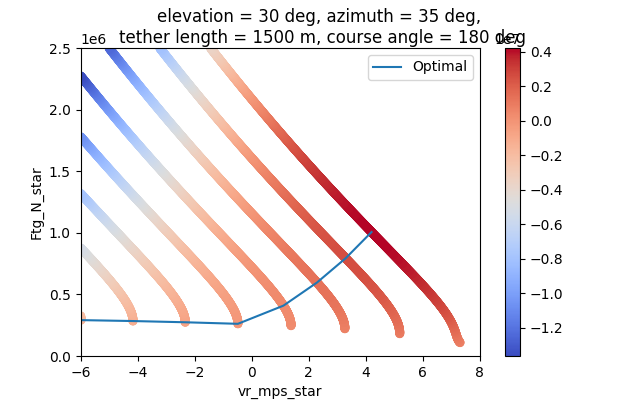

In [41]:
fig, ax = plt.subplots(1, 1, figsize=PARTSIZE)


beta_deg_bar = 30
phi_deg_bar = 35
chi_deg_bar = 180
Lt_m_bar = 1500
df_optimal = qss_star[
    (qss_star["Lt_m"] == Lt_m_bar)
    & (qss_star["beta_deg"] == beta_deg_bar)
    & (qss_star["phi_deg"] == phi_deg_bar)
    & (qss_star["chi_deg"] == chi_deg_bar)
]

fig.suptitle(f"elevation = {beta_deg_bar} deg, azimuth = {phi_deg_bar} deg, \ntether length = {Lt_m_bar} m, course angle = {chi_deg_bar} deg")


sns.lineplot(
    df_optimal,
    x="vr_mps_star",
    y="Ftg_N_star",
)
ax.legend(["Optimal"])

qss_bar = qss.df[
    (qss.df["Lt_m"] == Lt_m_bar)
    & (qss.df["beta_deg"] == beta_deg_bar)
    & (qss.df["phi_deg"] == phi_deg_bar)
    & (qss.df["chi_deg"] == chi_deg_bar)
]

temp = qss_bar[
    (qss_bar["vr_mps"] > -6)
    & (qss_bar["vr_mps"] < 8)
    & (qss_bar["Ftg_N"] > 0)
    & (qss_bar["Ftg_N"] < 2.5e6)
]

cmap = plt.cm.get_cmap("coolwarm")
normalize = plt.Normalize(vmin=temp["P_W"].min(), vmax=temp["P_W"].max())

sns.scatterplot(
    temp,
    x="vr_mps",
    y="Ftg_N",
    hue="P_W",
    palette=cmap,
    ax=ax,
    # marker=',',
    edgecolor=None,
    legend=False,
)

plt.ylim([0, 2.5e6])
plt.xlim([-6, 8])

sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sm.set_array([])
clb = plt.colorbar(sm, ax=ax)
clb.ax.set_title(var_to_label["P_W"])

ax.grid()
set_labels(ax)
plt.tight_layout()
plt.savefig("../results/vrFt_SI.png")


In [ ]:
# Making the same graph in plotly is very easy.
px.scatter(temp, x="vr_mps", y="Ftg_N", color="P_W")

In [ ]:
# Least-squares fit around 0.0.5e6 tether force.
temp = qss_bar[
    (qss_bar["vr_mps"] > -6)
    & (qss_bar["vr_mps"] < 8)
    & (qss_bar["Ftg_N"] > 0.45e6)
    & (qss_bar["Ftg_N"] < 0.55e6)
    # & (temp_nona['P_W'] > 0)
]

temp_nona = temp.dropna()

# Building the X matrix. (input data)
vr = temp_nona["vr_mps"].values
vr2 = vr**2
vw = temp_nona["vw_mps"].values
vw2 = vw**2
ones = np.ones_like(vr)
X = np.asarray([ones, vr, vw]).transpose()
# X = np.asarray([ones, vr, vw, vr**2, vw**2]).transpose()

# Outputs.
y = temp_nona["Ftg_N"].values

# Least-squares.
theta_hat = least_squares(X, y)
theta_hat


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=PARTSIZE)
fig.suptitle(f"elevation = {beta_deg_bar} deg, azimuth = {phi_deg_bar} deg, \ntether length = {Lt_m_bar} m, course angle = {chi_deg_bar} deg")

temp = qss_bar[
    (qss_bar["vr_mps"] > -6)
    & (qss_bar["vr_mps"] < 8)
    & (qss_bar["Ftg_N"] > 0)
    & (qss_bar["Ftg_N"] < 2.5e6)
    # & (qss_bar['vw_mps'] % 5 == 0)
]

for vw, df in temp.groupby("vw_mps"):
    df = df.sort_values(by="Ftg_N")
    plt.plot(df["vr_mps"], df["Ftg_N"], label=vw)

ax.legend(bbox_to_anchor=(1.1, 1.05), title="vw_mps")

plt.gca().set_prop_cycle(None)
for vw in temp["vw_mps"].unique():
    vr = np.linspace(-6, 8, 100)
    Ft_hat = (
        theta_hat[0]
        + theta_hat[1] * vr
        + theta_hat[2] * vw
        # + theta_hat[3] * vr**2
        # + theta_hat[4] * vw**2
    )
    plt.plot(vr, Ft_hat, "--")

plt.ylim([0, 2.5e6])
plt.xlim([-6, 8])

plt.xlabel("vr_mps")
plt.ylabel("Ftg_N")

ax.grid()
set_labels(ax)
plt.tight_layout()
plt.savefig("../results/vrFt_SI_fit.png")
